In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PlotSettings import MainColor1, MainColor2, MainColor3, BackgroundColor3, BackgroundColor1, BackgroundColor2, Gray1, Gray2
from CrossSections import  sigmaV_to_ZZ_Approx, Transfer_sigma
from Constants import DensityFactor, Mp, mm

from scipy.integrate import quad, odeint
from scipy import misc, special, optimize

import matplotlib.patches as mpatches




## Small Scales (SIDM)

C:\Users\Nicolás\AppData\Local\Temp\ipykernel_9296\1014452383.py:72: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


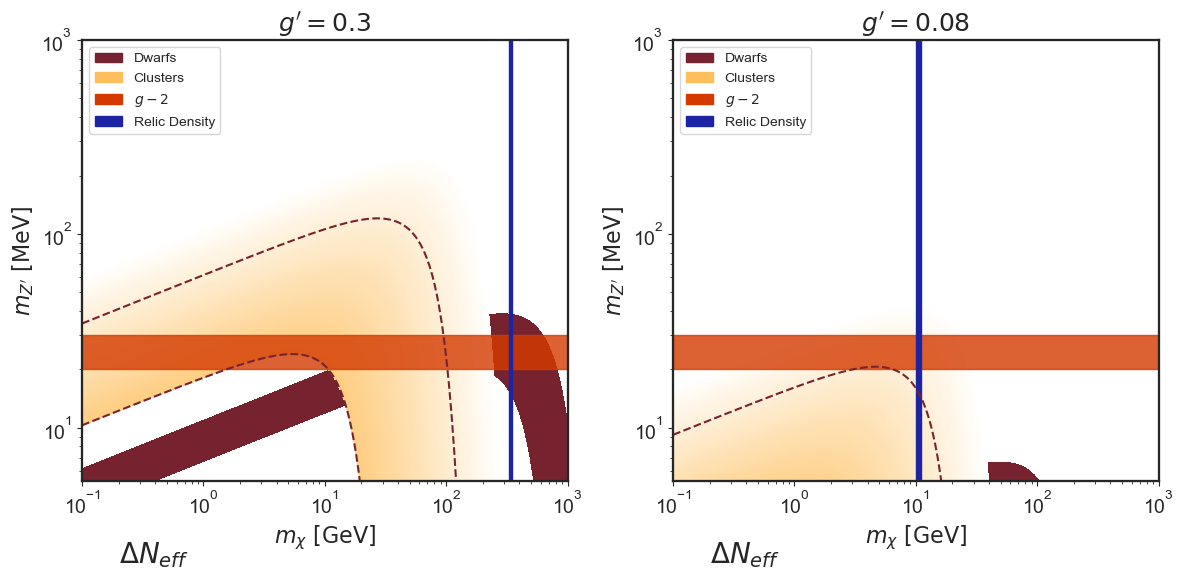

In [3]:
gp_l = (0.3, 8e-2)  

g_p = 200 #Grid Points
M_l = np.logspace(np.log10(5.3), 3, g_p)
m_l = np.logspace(-1, 3, g_p)

#Grids
M_g, m_g = np.meshgrid(M_l, m_l)
sigma_grid_dwarf = np.zeros((g_p, g_p))
sigma_grid_clusters = np.zeros((g_p, g_p))

n = 50
levels_dw=[10, 70]
levels_cl= np.logspace(-3, 0.1, n+1)  # Generate logarithmically spaced values
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.ravel()

#Colors
clusterColors = BackgroundColor3
DwColors =BackgroundColor1
Muoncolors = MainColor3
RelicColors = MainColor2


fig_index = 0

patch_dw = mpatches.Patch(color=DwColors, label=r'Dwarfs')
patch_cl = mpatches.Patch(color=clusterColors, label=r'Clusters')
patch_g2 = mpatches.Patch(color=Muoncolors, label=r'$g-2$')
patch_Oh2 = mpatches.Patch(color=RelicColors, label=r'Relic Density')

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(c1)
    c2=np.array(c2)
    return (1-mix)*c1 + mix*c2

c2 = clusterColors  # yellow
c1 = (1, 1, 1)  # white
clf = [colorFader(c1, c2, (np.log10(l) + 3)/4) for l in levels_cl]

for g in gp_l:
    
    for i in range(g_p):
        for j in range(g_p):
            sigma_grid_dwarf[i, j] = Transfer_sigma(30, g, M_l[j], m_l[i])
            sigma_grid_clusters[i, j] = Transfer_sigma(1000, g, M_l[j], m_l[i])

    ax[fig_index].set_title('$g^{{\prime}} = {}$'.format(g))
    
    ax[fig_index].contourf(m_g, M_g, sigma_grid_dwarf, levels_dw, colors=(DwColors,))
    ax[fig_index].contourf(m_g, M_g, sigma_grid_clusters, levels_cl, colors=clf)
    ax[fig_index].contour(m_g, M_g, sigma_grid_clusters, [0.01, levels_cl[-1] ], colors=(DwColors,), linestyles='dashed')
    
    ax[fig_index].fill_between(m_l, y1=20, y2=30, color=Muoncolors, alpha=0.8)
    ax[fig_index].text(0.2, 2, r'$\Delta N_{eff}$', fontsize=20)    
    #ax[fig_index].fill_between(m_l, M_l[0], 5.3, color=Gray1, alpha=0.6) 
    ax[fig_index].set_xlabel('$m_{\chi} ~[\mathrm{GeV} ]$' )
    ax[fig_index].set_ylabel('$m_{Z\'} ~[\mathrm{MeV} ]$' )
    ax[fig_index].set_xscale('log')
    ax[fig_index].set_yscale('log')
    ax[fig_index].legend(handles=[patch_dw, patch_cl, patch_g2, patch_Oh2], loc='upper left')

    fig_index +=1


#Relic Density
ax[0].fill_between(([330, 350]), y1=M_l[0], y2=M_l[-1], color=RelicColors)
ax[1].fill_between(([10, 11]), y1=M_l[0], y2=M_l[-1], color=RelicColors)


fig.tight_layout()
fig.show()
fig.savefig("Plots/ParameterSpacePlot.pdf")
fig.savefig("Plots/ParameterSpacePlot.svg")

The mixing constraints from Direct Detections experiments is shown below

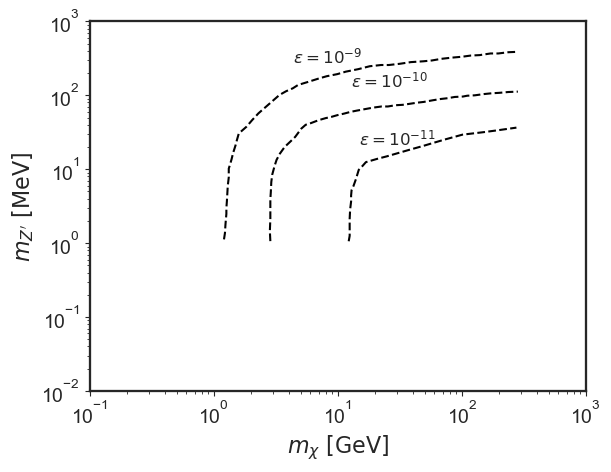

<Figure size 640x480 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt


MixingConstraints1 = np.loadtxt("Data-Sets/Mixing-Constraints(1).csv", delimiter=",")
MixingConstraints2 = np.loadtxt("Data-Sets/Mixing-Constraints(2).csv", delimiter=",")
MixingConstraints3 = np.loadtxt("Data-Sets/Mixing-Constraints(3).csv", delimiter=",")

MixingConstraints1_mcoordinate = MixingConstraints1[:,0]
MixingConstraints1_Mcoordinate = MixingConstraints1[:,1]

MixingConstraints2_mcoordinate = MixingConstraints2[:,0]
MixingConstraints2_Mcoordinate = MixingConstraints2[:,1]

MixingConstraints3_mcoordinate = MixingConstraints3[:,0]
MixingConstraints3_Mcoordinate = MixingConstraints3[:,1]


plt.plot(MixingConstraints1_mcoordinate, MixingConstraints1_Mcoordinate, '--', color='k')
plt.plot(MixingConstraints2_mcoordinate, MixingConstraints2_Mcoordinate, '--', color='k')
plt.plot(MixingConstraints3_mcoordinate, MixingConstraints3_Mcoordinate, '--', color='k')

# Adding text labels to the curves
plt.text(MixingConstraints1_mcoordinate[len(MixingConstraints1_mcoordinate)//2] , 
         MixingConstraints1_Mcoordinate[len(MixingConstraints1_Mcoordinate)//2]*2, 
         r'$\epsilon = 10^{-9}$', fontsize=12, verticalalignment='bottom')

plt.text(MixingConstraints2_mcoordinate[len(MixingConstraints2_mcoordinate)//2], 
         MixingConstraints2_Mcoordinate[len(MixingConstraints2_Mcoordinate)//2]*2, 
         r'$\epsilon = 10^{-10}$', fontsize=12, verticalalignment='bottom')

plt.text(MixingConstraints3_mcoordinate[len(MixingConstraints3_mcoordinate)//2], 
         MixingConstraints3_Mcoordinate[len(MixingConstraints3_Mcoordinate)//2]*2, 
         r'$\epsilon = 10^{-11}$', fontsize=12, verticalalignment='bottom')

plt.xlabel(r'$m_{\chi} ~[\mathrm{GeV} ]$')
plt.ylabel('$m_{Z\'} ~[\mathrm{MeV} ]$' ) 
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.1, 1e3)
plt.ylim(0.01, 1e3)
plt.show()
plt.savefig('MixingConstraints.pdf')

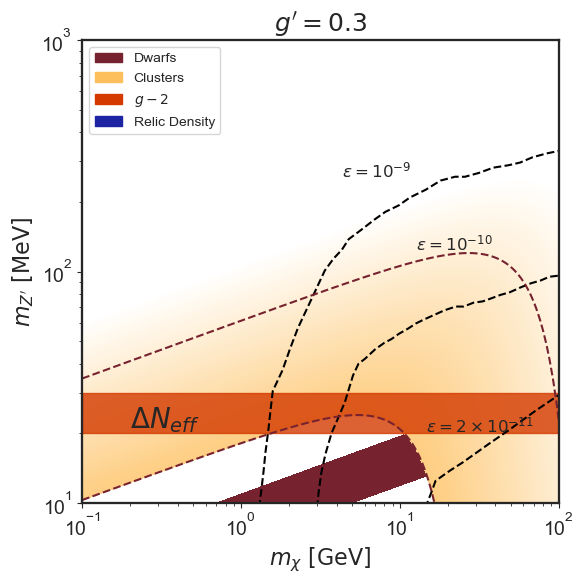

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define parameters
gp_l = (0.3, 8e-2)
g_p = 200  # Grid Points
M_l = np.logspace(np.log10(5.3), 3, g_p)
m_l = np.logspace(-1, 3, g_p)

# Grids
M_g, m_g = np.meshgrid(M_l, m_l)
sigma_grid_dwarf = np.zeros((g_p, g_p))
sigma_grid_clusters = np.zeros((g_p, g_p))

n = 50
levels_dw = [10, 70]
levels_cl = np.logspace(-3, 0.1, n+1)

# Colors
clusterColors = BackgroundColor3
DwColors = BackgroundColor1
Muoncolors = MainColor3
RelicColors = MainColor2

patch_dw = mpatches.Patch(color=DwColors, label=r'Dwarfs')
patch_cl = mpatches.Patch(color=clusterColors, label=r'Clusters')
patch_g2 = mpatches.Patch(color=Muoncolors, label=r'$g-2$')
patch_Oh2 = mpatches.Patch(color=RelicColors, label=r'Relic Density')

# Function to fade colors
def colorFader(c1, c2, mix=0):
    c1 = np.array(c1)
    c2 = np.array(c2)
    return (1-mix)*c1 + mix*c2

c2 = clusterColors
c1 = (1, 1, 1)  
clf = [colorFader(c1, c2, (np.log10(l) + 3)/4) for l in levels_cl]

# Extract and plot the left subplot
fig_left, ax_left = plt.subplots(figsize=(6, 6))

g = gp_l[0]  # Extract first value (left plot)

for i in range(g_p):
    for j in range(g_p):
        sigma_grid_dwarf[i, j] = Transfer_sigma(30, g, M_l[j], m_l[i])
        sigma_grid_clusters[i, j] = Transfer_sigma(1000, g, M_l[j], m_l[i])

ax_left.set_title('$g^{{\prime}} = {}$'.format(g))



plt.plot(MixingConstraints1_mcoordinate, MixingConstraints1_Mcoordinate, '--', color='k')
plt.plot(MixingConstraints2_mcoordinate, MixingConstraints2_Mcoordinate, '--', color='k')
plt.plot(MixingConstraints3_mcoordinate, MixingConstraints3_Mcoordinate, '--', color='k')

# Adding text labels to the curves
plt.text(MixingConstraints1_mcoordinate[len(MixingConstraints1_mcoordinate)//2] , 
         MixingConstraints1_Mcoordinate[len(MixingConstraints1_Mcoordinate)//2]*2, 
         r'$\epsilon = 10^{-9}$', fontsize=12, verticalalignment='bottom')

plt.text(MixingConstraints2_mcoordinate[len(MixingConstraints2_mcoordinate)//2], 
         MixingConstraints2_Mcoordinate[len(MixingConstraints2_Mcoordinate)//2]*2, 
         r'$\epsilon = 10^{-10}$', fontsize=12, verticalalignment='bottom')

plt.text(MixingConstraints3_mcoordinate[len(MixingConstraints3_mcoordinate)//2], 
         MixingConstraints3_Mcoordinate[len(MixingConstraints3_Mcoordinate)//2]*2, 
         r'$\epsilon =2 \times 10^{-11}$', fontsize=12, verticalalignment='bottom')


ax_left.contourf(m_g, M_g, sigma_grid_dwarf, levels_dw, colors=(DwColors,))
ax_left.contourf(m_g, M_g, sigma_grid_clusters, levels_cl, colors=clf)
ax_left.contour(m_g, M_g, sigma_grid_clusters, [0.01, levels_cl[-1]], colors=(DwColors,), linestyles='dashed')

ax_left.fill_between(m_l, y1=20, y2=30, color=Muoncolors, alpha=0.8)
ax_left.text(0.2, 21, r'$\Delta N_{eff}$', fontsize=20)

ax_left.set_xlabel('$m_{\chi} ~[\mathrm{GeV} ]$')
ax_left.set_ylabel('$m_{Z\'} ~[\mathrm{MeV} ]$')
ax_left.set_xscale('log')
ax_left.set_yscale('log')
ax_left.set_xlim(0.1, 1e2)
ax_left.set_ylim(10, 1e3)

ax_left.legend(handles=[patch_dw, patch_cl, patch_g2, patch_Oh2], loc='upper left')

# Save the separate plot
fig_left.tight_layout()
fig_left.savefig("Plots/ParameterSpacePlot_Left.pdf")
fig_left.savefig("Plots/ParameterSpacePlot_Left.svg")
plt.show()


## Plot for the parameter space of the DM 

<Figure size 1000x600 with 0 Axes>

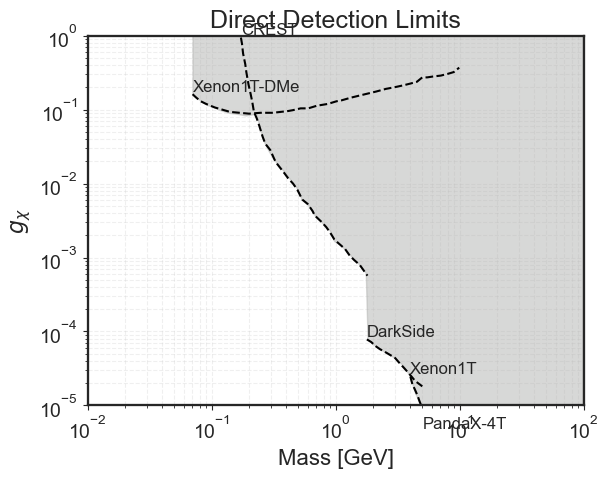

In [ ]:
plt.figure(figsize=(10, 6))  # width = 10 inches, height = 6 inches


#Colors
clusterColors = BackgroundColor3
DwColors =BackgroundColor1
Muoncolors = MainColor3
RelicColors = MainColor2


patch_dw = mpatches.Patch(color=DwColors, label=r'Dwarfs')
patch_cl = mpatches.Patch(color=clusterColors, label=r'Clusters')
patch_g2 = mpatches.Patch(color=Muoncolors, label=r'$g-2$')
patch_Oh2 = mpatches.Patch(color=RelicColors, label=r'Relic Density')

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(c1)
    c2=np.array(c2)
    return (1-mix)*c1 + mix*c2


################## | Direct Detection Data  | #################

# Optional: Create figure and set limits (you can adjust these)
plt.figure()
plt.yscale("log")
plt.xscale("log")

# Placeholder for ymax across all plots
y_max_global = 1  # You can also use plt.ylim() if the limits are dynamic


# Bottom Comstraints for Direct Detection Data
DarkShadow = np.loadtxt("Data-Sets/DirectDetection/DirectDetectionShadow.csv", delimiter=',')
DarkShadow_x = DarkShadow[:,0]
DarkShadow_y = DarkShadow[:,1]
plt.fill_between(DarkShadow_x, DarkShadow_y, y_max_global, color=Gray2, alpha=0.5)



#Xenon1T-DMe
Xenon1TDMe = np.loadtxt("Data-Sets/DirectDetection/Xenon1T-DMe.csv", delimiter=",")
Xenon1_x = Xenon1TDMe[:, 0]
Xenon1_y = Xenon1TDMe[:, 1]
plt.plot(Xenon1_x, Xenon1_y, '--', color='k')
plt.text(Xenon1_x[0], Xenon1_y[0]*1.1, "Xenon1T-DMe")


# CREST
CREST = np.loadtxt("Data-Sets/DirectDetection/CREST.csv", delimiter=",")
CREST_x = CREST[:, 0]
CREST_y = CREST[:, 1]
plt.plot(CREST_x, CREST_y, '--', color='k')
plt.text(CREST_x[0], CREST_y[0]*1.1, "CREST")

# DarkSide
DarkSide = np.loadtxt("Data-Sets/DirectDetection/DarkSide.csv", delimiter=",")
DarkSide_x = DarkSide[:, 0]
DarkSide_y = DarkSide[:, 1]
plt.plot(DarkSide_x, DarkSide_y, '--', color='k')
plt.text(DarkSide_x[0], DarkSide_y[0]*1.1, "DarkSide")

# PandaX-4T
PandaX_4T = np.loadtxt("Data-Sets/DirectDetection/PandaX-4T.csv", delimiter=",")
PandaX_4T_x = PandaX_4T[:, 0]
PandaX_4T_y = PandaX_4T[:, 1]
plt.plot(PandaX_4T_x, PandaX_4T_y, '--', color='k')
plt.text(PandaX_4T_x[0], PandaX_4T_y[0]*1.1, "PandaX-4T")

# Xenon1T
Xenon1T = np.loadtxt("Data-Sets/DirectDetection/Xenon1T.csv", delimiter=",")
Xenon1T_x = Xenon1T[:, 0]
Xenon1T_y = Xenon1T[:, 1]
plt.plot(Xenon1T_x, Xenon1T_y, '--', color='k'
plt.text(Xenon1T_x[0], Xenon1T_y[0]*1.1, "Xenon1T")

# Set plot limits last to ensure all fills are visible
plt.ylim(1e-5, y_max_global)
plt.xlim(1e-2, 1e2)

plt.xlabel("Mass [GeV]")
plt.ylabel("$g_{\chi}$")
plt.title("Direct Detection Limits")
plt.grid(True, which='both', ls='--', alpha=0.3)

plt.show()



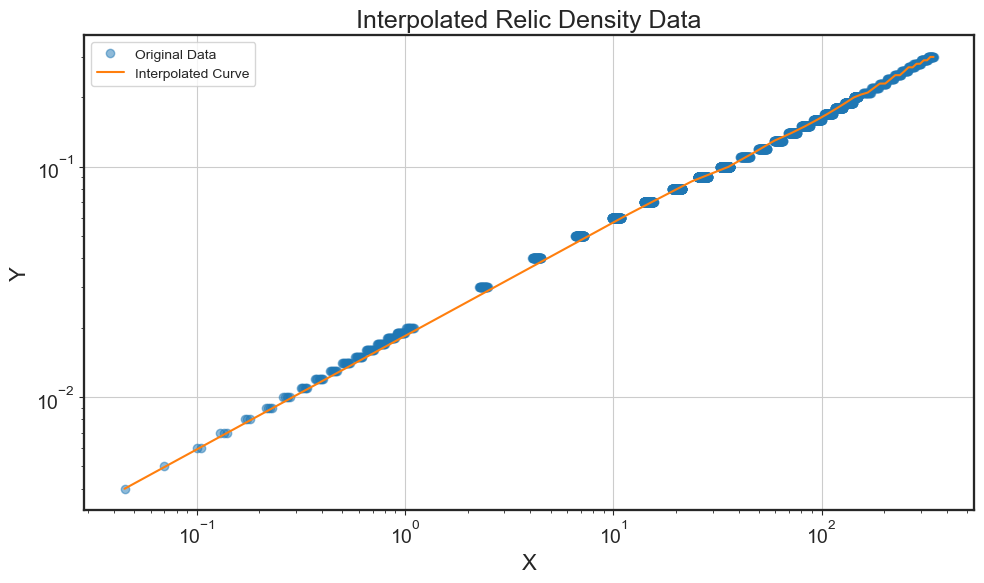

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Load CSV data
RelicData = np.loadtxt('Data-Sets/RelicDensityResults.csv', delimiter=',') 

# Combine all datasets into one
RelicDensitySpace = np.vstack((RelicData))

# Sort by x value (first column)
RelicDensitySpace = RelicDensitySpace[RelicDensitySpace[:, 0].argsort()]

# Remove duplicate x values by keeping the first occurrence
_, unique_indices = np.unique(RelicDensitySpace[:, 0], return_index=True)
RelicDensitySpace = RelicDensitySpace[unique_indices]

# Interpolation
x_vals = RelicDensitySpace[:, 0]
y_vals = RelicDensitySpace[:, 1]
interp_func = interp1d(x_vals, y_vals, kind='cubic', fill_value="extrapolate")
x_interp = np.linspace(x_vals.min(), x_vals.max(), 30)
y_interp = interp_func(x_interp)

# Plot original and interpolated data


#plt.plot(RelicData)
plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, 'o', label='Original Data', alpha=0.5)
plt.plot(x_interp, y_interp, '-', label='Interpolated Curve')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Interpolated Relic Density Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

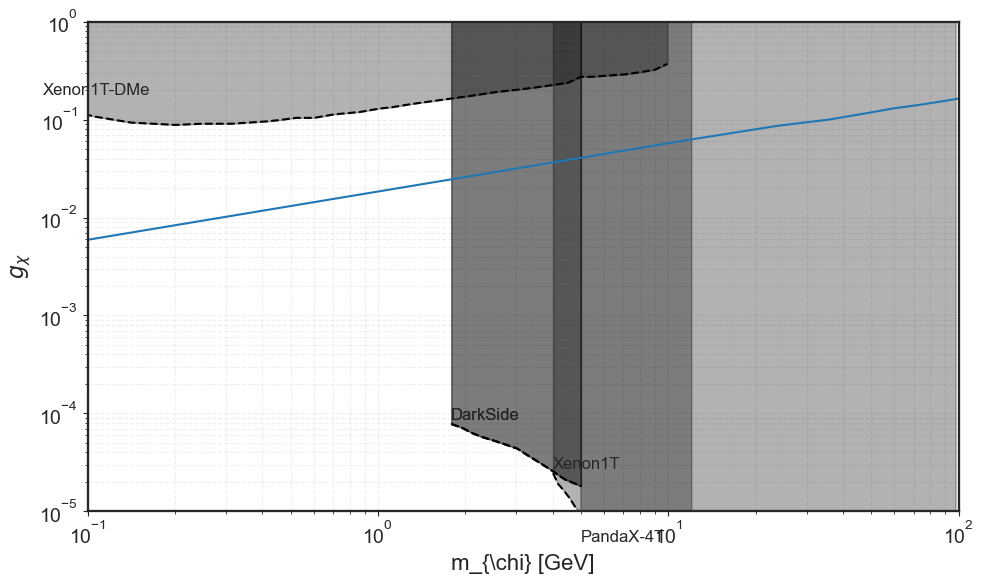

In [ ]:

#plt.plot(RelicData)
plt.figure(figsize=(10, 6))

plt.plot(x_interp, y_interp, '-', label='Interpolated Curve')
plt.xscale('log')
plt.yscale('log')



plt.plot(Xenon1_x, Xenon1_y, '--', color='k')
plt.fill_between(Xenon1_x, Xenon1_y, y_max_global, color='black', alpha=0.3)
plt.text(Xenon1_x[0], Xenon1_y[0]*1.1, "Xenon1T-DMe")


plt.plot(DarkSide_x, DarkSide_y, '--', color='k')
plt.fill_between(DarkSide_x, DarkSide_y, y_max_global, color='black', alpha=0.3)
plt.text(DarkSide_x[0], DarkSide_y[0]*1.1, "DarkSide")


plt.plot(DarkSide_x, DarkSide_y, '--', color='k')
plt.fill_between(DarkSide_x, DarkSide_y, y_max_global, color='black', alpha=0.3)
plt.text(DarkSide_x[0], DarkSide_y[0]*1.1, "DarkSide")



plt.plot(PandaX_4T_x, PandaX_4T_y, '--', color='k')
plt.fill_between(PandaX_4T_x, PandaX_4T_y, y_max_global, color='black', alpha=0.3)
plt.text(PandaX_4T_x[0], PandaX_4T_y[0]*1.1, "PandaX-4T")


plt.plot(Xenon1T_x, Xenon1T_y, '--', color='k')
plt.fill_between(Xenon1T_x, Xenon1T_y, y_max_global, color='black', alpha=0.3)
plt.text(Xenon1T_x[0], Xenon1T_y[0]*1.1, "Xenon1T")

# Set plot limits last to ensure all fills are visible
plt.ylim(1e-5, y_max_global)
plt.xlim(1e-1, 1e2)

plt.xlabel("m_{\chi} [GeV]")
plt.ylabel("$g_{\chi}$")
plt.grid(True, which='both', ls='--', alpha=0.3)


plt.tight_layout()

#plt.savefig("Plots/ParameterSpaceDM.pdf")
#plt.savefig("Plots/ParameterSpaceDM.svg")
plt.show()

### Small Scales

C:\Users\Nicolás\AppData\Local\Temp\ipykernel_9296\1592174360.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


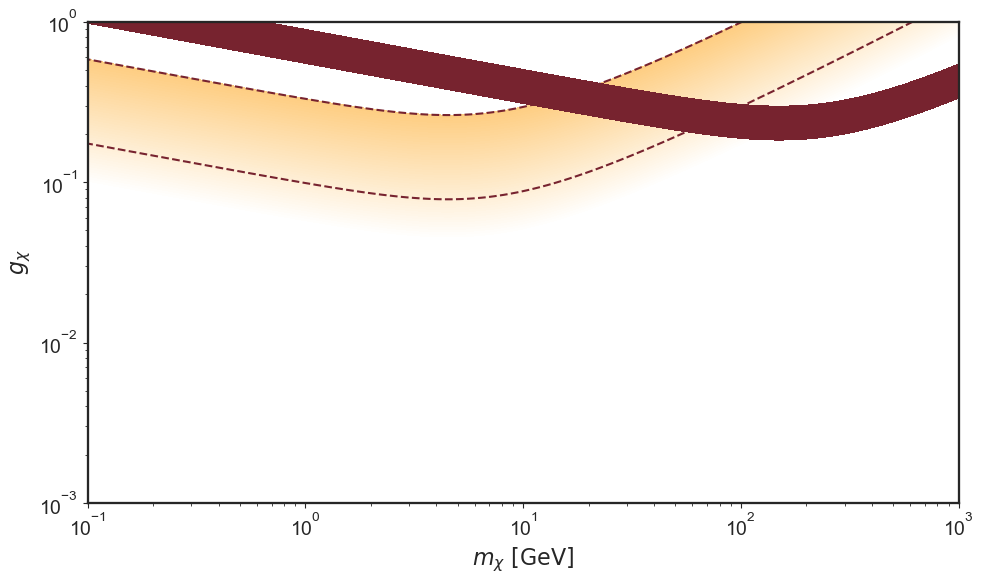

In [9]:

grid_pts = 200 #Grid Points
M = 20
g_chi = np.logspace(-3, 0, grid_pts)
m_l = np.logspace(-1, 3, grid_pts)

#Grids
g_g, m_g = np.meshgrid(g_chi, m_l)
sigma_grid_dwarf = np.zeros((grid_pts, grid_pts))
sigma_grid_clusters = np.zeros((grid_pts, grid_pts))

n = 50
levels_dw=[10, 70]
levels_cl= np.logspace(-3, 0.1, n+1)  # Generate logarithmically spaced values
fig, ax = plt.subplots(1, 1, figsize=(10, 6))


#Colors
clusterColors = BackgroundColor3
DwColors =BackgroundColor1
Muoncolors = MainColor3
RelicColors = MainColor2


patch_dw = mpatches.Patch(color=DwColors, label=r'Dwarfs')
patch_cl = mpatches.Patch(color=clusterColors, label=r'Clusters')
patch_g2 = mpatches.Patch(color=Muoncolors, label=r'$g-2$')
patch_Oh2 = mpatches.Patch(color=RelicColors, label=r'Relic Density')

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(c1)
    c2=np.array(c2)
    return (1-mix)*c1 + mix*c2

c2 = clusterColors  # yellow
c1 = (1, 1, 1)  # white
clf = [colorFader(c1, c2, (np.log10(l) + 3)/4) for l in levels_cl]



for i in range(grid_pts):
    for j in range(g_p):
        sigma_grid_dwarf[i, j] = Transfer_sigma(30, g_chi[j], M, m_l[i])
        sigma_grid_clusters[i, j] = Transfer_sigma(1000, g_chi[j], M, m_l[i])





ax.contourf(m_g, g_g, sigma_grid_clusters, levels_cl, colors=clf)
ax.contour(m_g, g_g, sigma_grid_clusters, [0.01, levels_cl[-1] ], colors=(DwColors,), linestyles='dashed')
ax.contourf(m_g, g_g, sigma_grid_dwarf, levels_dw, colors=(DwColors,))

ax.set_xlabel('$m_{\chi} ~[\mathrm{GeV} ]$' )
ax.set_ylabel('$g_{\chi} $' )
ax.set_xscale('log')
ax.set_yscale('log')
#ax[fig_index].legend(handles=[patch_dw, patch_cl, patch_g2, patch_Oh2], loc='upper left')


fig.tight_layout()
fig.show()



### Combined plots

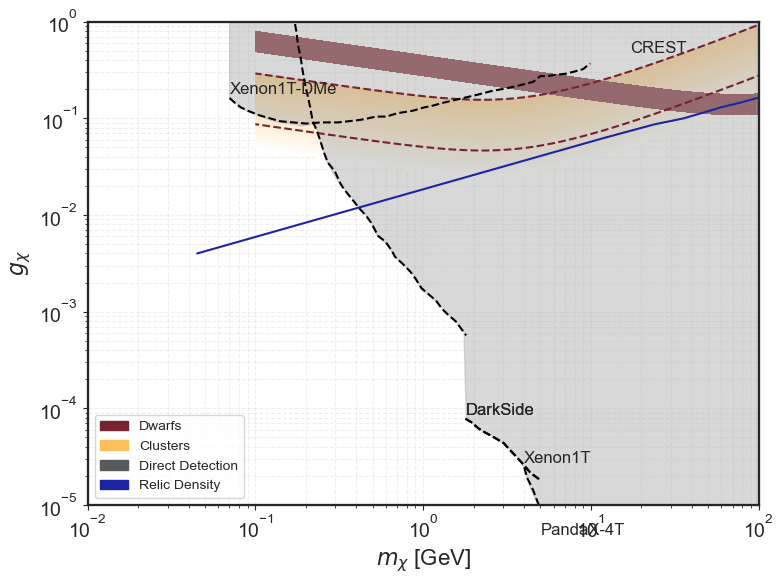

In [21]:

#Colors
clusterColors = BackgroundColor3
DwColors =BackgroundColor1
Muoncolors = MainColor3
RelicColors = MainColor2

#Plot Settings
plt.figure(figsize=(8, 6))

plt.plot(x_interp, y_interp, '-', label='Interpolated Curve', color=RelicColors)
plt.xscale('log')
plt.yscale('log')



# Settings for Astrophysics

grid_pts = 200 #Grid Points
M = 10
g_chi = np.logspace(-3, 0, grid_pts)
m_l = np.logspace(-1, 3, grid_pts)

#Grids
g_g, m_g = np.meshgrid(g_chi, m_l)
sigma_grid_dwarf = np.zeros((grid_pts, grid_pts))
sigma_grid_clusters = np.zeros((grid_pts, grid_pts))

n = 50
levels_dw=[10, 70]
levels_cl= np.logspace(-3, 0.1, n+1)  # Generate logarithmically spaced values


patch_dw = mpatches.Patch(color=DwColors, label=r'Dwarfs')
patch_cl = mpatches.Patch(color=clusterColors, label=r'Clusters')
patch_dd = mpatches.Patch(color=Gray1, label=r'Direct Detection')
patch_Oh2 = mpatches.Patch(color=RelicColors, label=r'Relic Density')

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(c1)
    c2=np.array(c2)
    return (1-mix)*c1 + mix*c2

c2 = clusterColors  # yellow
c1 = (1, 1, 1)  # white
clf = [colorFader(c1, c2, (np.log10(l) + 3)/4) for l in levels_cl]



for i in range(grid_pts):
    for j in range(g_p):
        sigma_grid_dwarf[i, j] = Transfer_sigma(30, g_chi[j], M, m_l[i])
        sigma_grid_clusters[i, j] = Transfer_sigma(1000, g_chi[j], M, m_l[i])





plt.contourf(m_g, g_g, sigma_grid_clusters, levels_cl, colors=clf)
plt.contour(m_g, g_g, sigma_grid_clusters, [0.01, levels_cl[-1] ], colors=(DwColors,), linestyles='dashed')
plt.contourf(m_g, g_g, sigma_grid_dwarf, levels_dw, colors=(DwColors,))

plt.legend(handles=[patch_dw, patch_cl, patch_dd, patch_Oh2], loc='lower left')

#Fill the constrained region by direct detectipn
plt.fill_between(DarkShadow_x, DarkShadow_y, y_max_global, color=Gray2, alpha=0.5)

# Plot for Direct Constraints
plt.plot(Xenon1_x, Xenon1_y, '--', color='k')
#plt.fill_between(Xenon1_x, Xenon1_y, y_max_global, color='black', alpha=0.3)
plt.text(Xenon1_x[0], Xenon1_y[0]*1.1, "Xenon1T-DMe")


plt.plot(DarkSide_x, DarkSide_y, '--', color='k')
#plt.fill_between(DarkSide_x, DarkSide_y, y_max_global, color='black', alpha=0.3)
plt.text(DarkSide_x[0], DarkSide_y[0]*1.1, "DarkSide")


plt.plot(DarkSide_x, DarkSide_y, '--', color='k')
#plt.fill_between(DarkSide_x, DarkSide_y, y_max_global, color='black', alpha=0.3)
plt.text(DarkSide_x[0], DarkSide_y[0]*1.1, "DarkSide")

plt.plot(CREST_x, CREST_y, '--', color='k')
#plt.fill_between(CREST_x, CREST_y, y_max_global, color='black', alpha=0.6)
plt.text(CREST_x[0]*100, CREST_y[0]*0.5, "CREST")



plt.plot(Xenon1T_x, Xenon1T_y, '--', color='k')
#plt.fill_between(Xenon1T_x, Xenon1T_y, y_max_global, color='black', alpha=0.3)
plt.text(Xenon1T_x[0], Xenon1T_y[0]*1.1, "Xenon1T")


plt.plot(PandaX_4T_x, PandaX_4T_y, '--', color='k')
#plt.fill_between(PandaX_4T_x, PandaX_4T_y, y_max_global, color='black', alpha=0.3)
plt.text(PandaX_4T_x[0], PandaX_4T_y[0]*1.1, "PandaX-4T")



# Set plot limits last to ensure all fills are visible
plt.ylim(1e-5, y_max_global)
plt.xlim(1e-2, 1e2)


plt.xlabel("$m_{\chi}$ [GeV]")
plt.ylabel("$g_{\chi}$")
plt.grid(True, which='both', ls='--', alpha=0.3)


plt.tight_layout()

plt.savefig("Plots/ParameterSpaceDM.pdf")
plt.savefig("Plots/ParameterSpaceDM.svg")
plt.show()


